# 1.确定初始参数

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

n=200
l=1.0
x_vals=y_vals=np.linspace(0,l,n+1)
x_grid,y_grid=np.meshgrid(x_vals,y_vals)
dx=dy=l/n
num_steps=20000
output_interval=2500
visc=0.001 #运动粘度
dt=0.004

# 2. 初始化速度场

In [33]:
u=np.zeros((n+1,n+1))
v=np.zeros((n+1,n+1))
u[-1,1:-1]=np.sin(np.pi*x_vals[1:-1])**2 #上边界给出的速度分布，不包括左右边界
vorticity=np.zeros_like(u)
stream_fn=np.zeros_like(u)

# 3. 函数定义

- [参考“持筹涡算（一）：NS方程的流函数-涡量形式”](https://zhuanlan.zhihu.com/p/462572003)

In [37]:
def compute_vorticity(u,v,dx,dy):  #根据初始速度场初始化涡量场
    vort=np.zeros_like(u)
    vort[1:-1,1:-1]=(v[1:-1,2:]-v[1:-1,:-2])/(2*dx)-(u[2:,1:-1]-u[:-2,1:-1])/(2*dy)
    return vort

def apply_vorticity_bc(psi,u,v,vort): #使用Thom公式计算边界上的涡量
    vort[:,0]=2/dx**2*(psi[:,0]-psi[:,1])-2/dx*v[:,0]
    vort[:,-1]=2/dx**2*(psi[:,-1]-psi[:,-2])+2/dx*v[:,-1]
    vort[0,:]=2/dy**2*(psi[0,:]-psi[1,:])+2/dy*u[0,:]
    vort[-1,:]=2/dy**2*(psi[-1,:]-psi[-2,:])-2/dy*u[-1,:]

def solve_streamfn(vort,dx,dy,tol=1e-5,psi_guess=None):#Jacobi迭代
    if psi_guess is None:
        psi_guess=np.zeros_like(vort)
    diff=5.0
    while diff > tol:
        psi_new=psi_guess.copy()
        psi_new[1:-1,1:-1]=(vort[1:-1,1:-1]+(psi_guess[2:,1:-1]+psi_guess[:-2,1:-1])/dy**2+(psi_guess[1:-1,2:]+psi_guess[1:-1,:-2])/dx**2)/(2/dx**2+2/dy**2)
        diff=np.max(np.abs(psi_new-psi_guess))
        psi_guess=psi_new
    return psi_guess

def evolve_vorticity(psi,vort,dx,dy,dt,nu): #涡传输方程
    convect_u=-(psi[2:,1:-1]-psi[:-2,1:-1])*(vort[1:-1,2:]-vort[1:-1,:-2])/(4*dx*dy)
    convect_v=(psi[1:-1,2:]-psi[1:-1,:-2])*(vort[2:,1:-1]-vort[:-2,1:-1])/(4*dx*dy)
    diff_x=nu*(vort[1:-1,2:]+vort[1:-1,:-2]-2*vort[1:-1,1:-1])/dx**2
    diff_y=nu*(vort[2:,1:-1]+vort[:-2,1:-1]-2*vort[1:-1,1:-1])/dy**2
    vort[1:-1,1:-1]+=dt*(convect_u+convect_v+diff_x+diff_y)
    return vort

def streamfn_to_velocity(psi,dx,dy,u,v):
    u[1:-1,1:-1]=(psi[2:,1:-1]-psi[:-2,1:-1])/(2*dy)
    v[1:-1,1:-1]=-(psi[1:-1,2:]-psi[1:-1,:-2])/(2*dx)
    return u,v

def visualize(psi, u, v, step):
    speed = np.sqrt(u**2+v**2)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(speed, origin='lower', cmap='viridis')
    plt.colorbar(label='|velocity|')
    plt.title(f'Speed at step {step}') #速度场

    # plt.subplot(2, 2, 2)
    # plt.plot(y_vals, u[:, n//2])
    # plt.title('Vertical u at center')
    # plt.xlabel('y')
    # plt.ylabel('u') #中间线上的速度剖面

    # plt.subplot(2, 2, 3)
    # plt.plot(x_vals, v[n//2, :])
    # plt.title('Horizontal v at center')
    # plt.xlabel('x')
    # plt.ylabel('v') #中间线上的速度剖面

    plt.subplot(1, 2, 2)
    levels = np.linspace(np.min(psi), np.max(psi), 100)
    plt.contour(x_grid, y_grid, psi, levels=levels, cmap='coolwarm')
    plt.colorbar(label='Streamfunction')
    plt.title(f'Streamlines at step {step}') #流线图

    plt.tight_layout()
    plt.savefig(f"Results_at_{step}.png")
    plt.show()


def visualize_velocity_profiles_over_time(u_history, v_history, x_vals, y_vals, steps_recorded):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for u, step in zip(u_history, steps_recorded):
        plt.plot(y_vals, u[:, len(x_vals) // 2], label=f'Step {step}')
    plt.title('Vertical profile of u at center (x=L/2)')
    plt.xlabel('y')
    plt.ylabel('u')
    plt.legend()

    plt.subplot(1, 2, 2)
    for v, step in zip(v_history, steps_recorded):
        plt.plot(x_vals, v[len(y_vals) // 2, :], label=f'Step {step}')
    plt.title('Horizontal profile of v at center (y=L/2)')
    plt.xlabel('x')
    plt.ylabel('v')
    plt.legend()

    plt.tight_layout()
    plt.savefig("Center.png")
    plt.show()

def analyze_vortices(psi):
    core_idx = scipy.ndimage.minimum_position(psi)
    core_val = np.min(psi) #找到主涡的最小点
    print(f"Primary vortex center (y,x): {core_idx},streamfn={core_val:.4f}")

    labeled,num = scipy.ndimage.label(psi < 0) #使用连通区域分析来找到负的流函数区域，
    centers = scipy.ndimage.center_of_mass(psi < 0,labeled,range(1,num+1))
    if len(centers) > 1:
        print(f"Secondary/Tertiary vortex centers: {centers[1:]}")

# 4. 模拟

Step: 2500


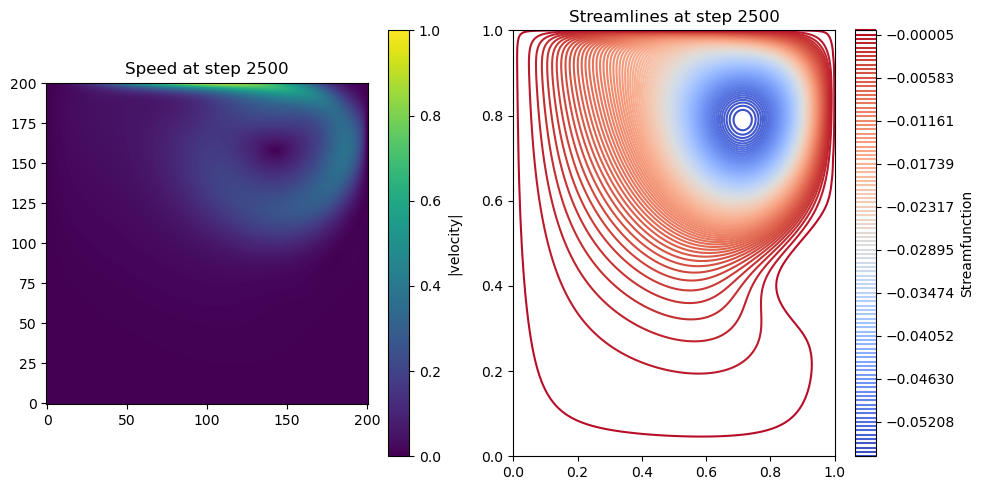

Primary vortex center (y,x): (158, 143),streamfn=-0.0567
Step: 5000


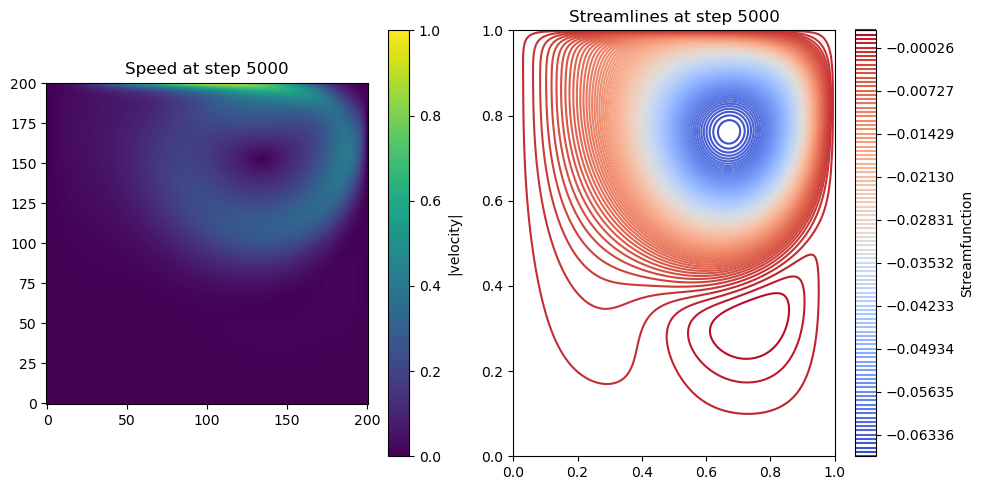

Primary vortex center (y,x): (152, 134),streamfn=-0.0669
Secondary/Tertiary vortex centers: [(2.0, 198.0)]
Step: 7500


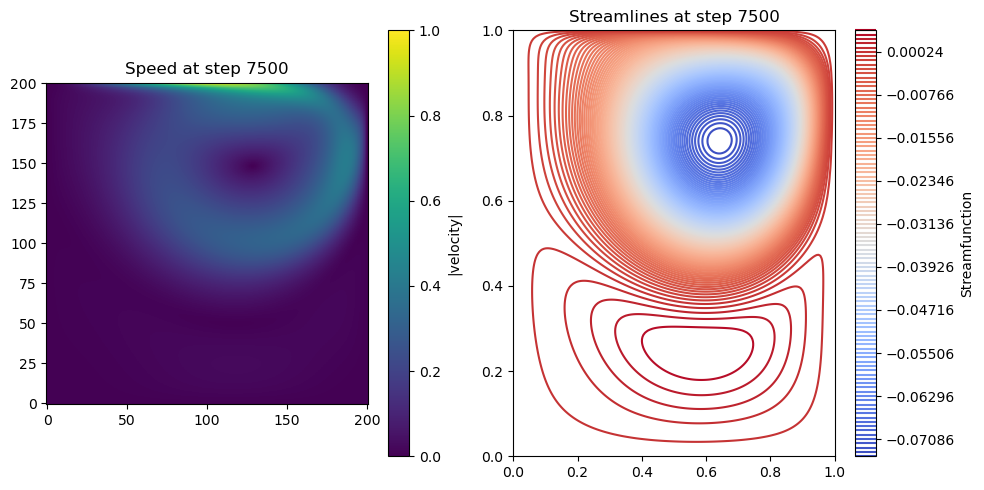

Primary vortex center (y,x): (148, 128),streamfn=-0.0740
Secondary/Tertiary vortex centers: [(3.0, 197.0), (142.1375715363116, 102.51049199236947)]
Step: 10000


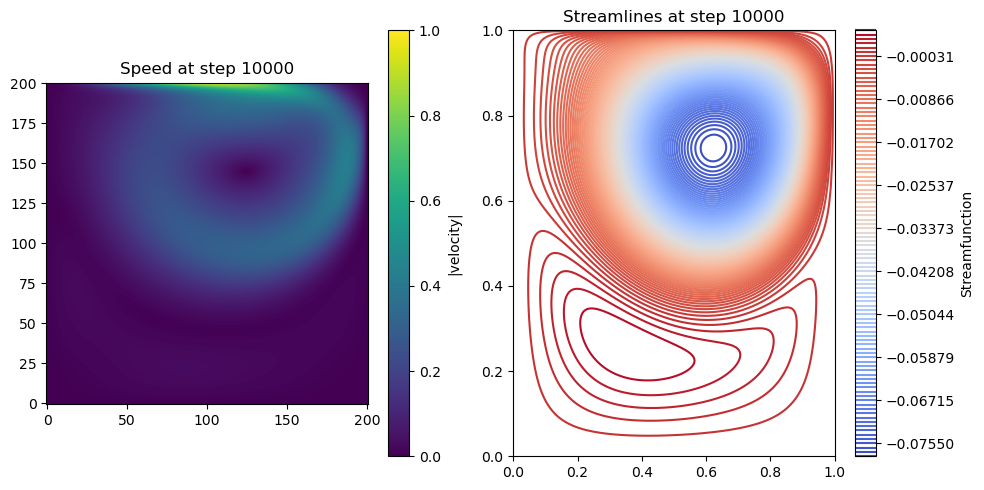

Primary vortex center (y,x): (145, 125),streamfn=-0.0780
Secondary/Tertiary vortex centers: [(3.6666666666666665, 196.33333333333334), (140.2947094535993, 104.36474414570685)]
Step: 12500


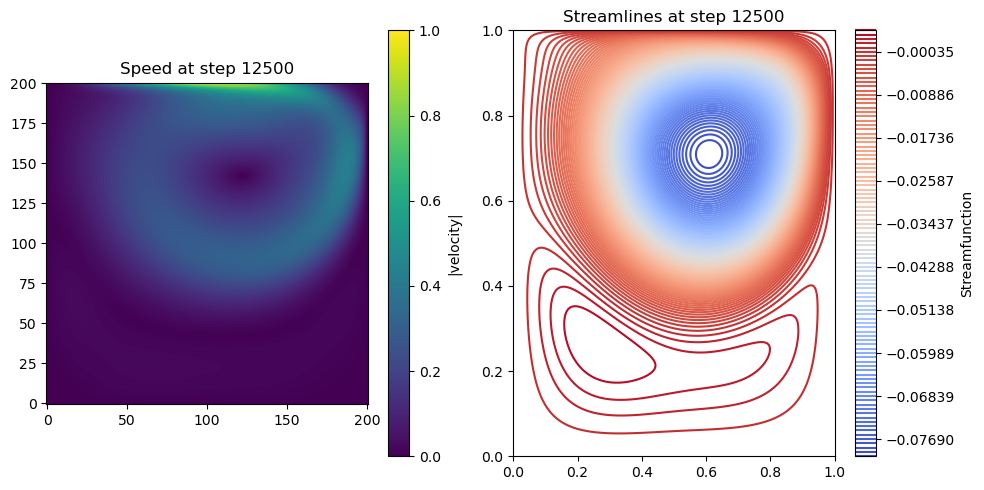

Primary vortex center (y,x): (142, 122),streamfn=-0.0803
Secondary/Tertiary vortex centers: [(3.0, 197.0), (136.88105061067768, 103.1978268861566)]
Step: 15000


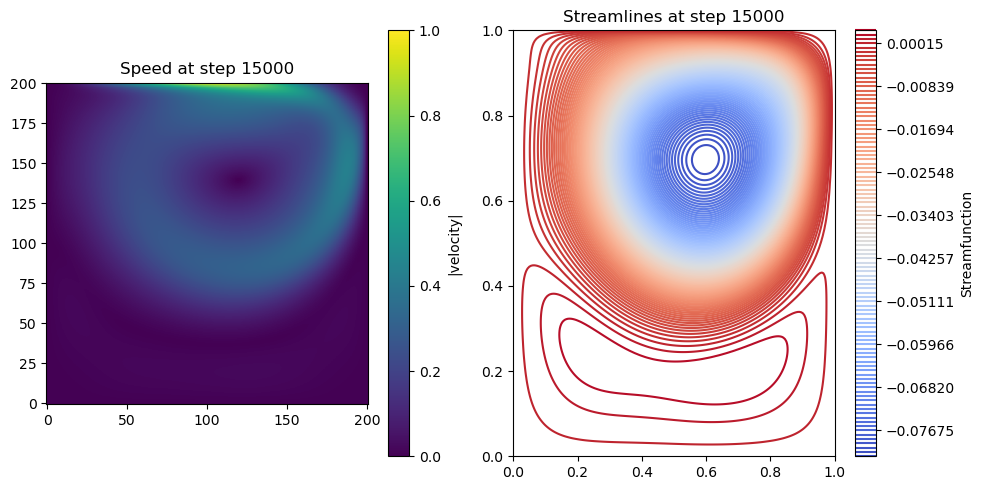

Primary vortex center (y,x): (139, 120),streamfn=-0.0819
Secondary/Tertiary vortex centers: [(2.6666666666666665, 197.33333333333334), (133.33467928011075, 101.43977849561605)]
Step: 17500


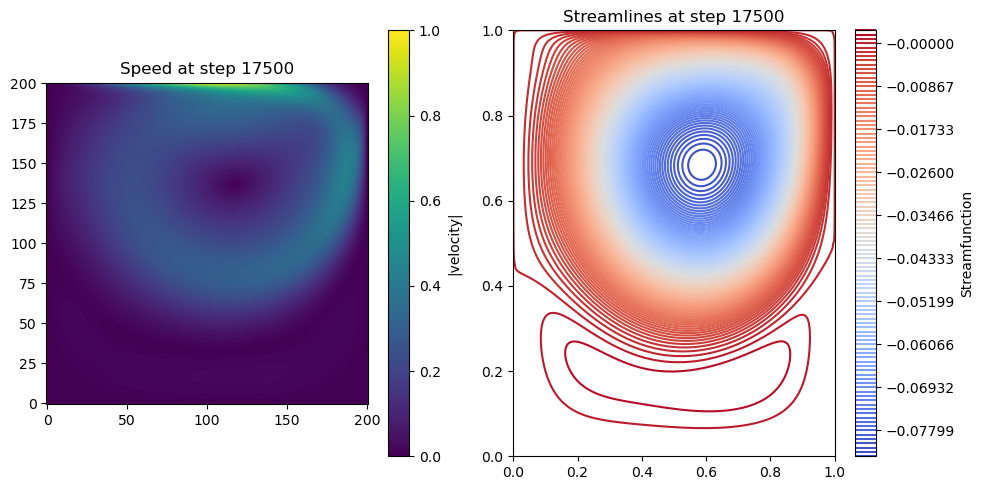

Primary vortex center (y,x): (137, 118),streamfn=-0.0832
Secondary/Tertiary vortex centers: [(2.6666666666666665, 197.33333333333334), (130.39360099915513, 100.37780553208684)]
Step: 20000


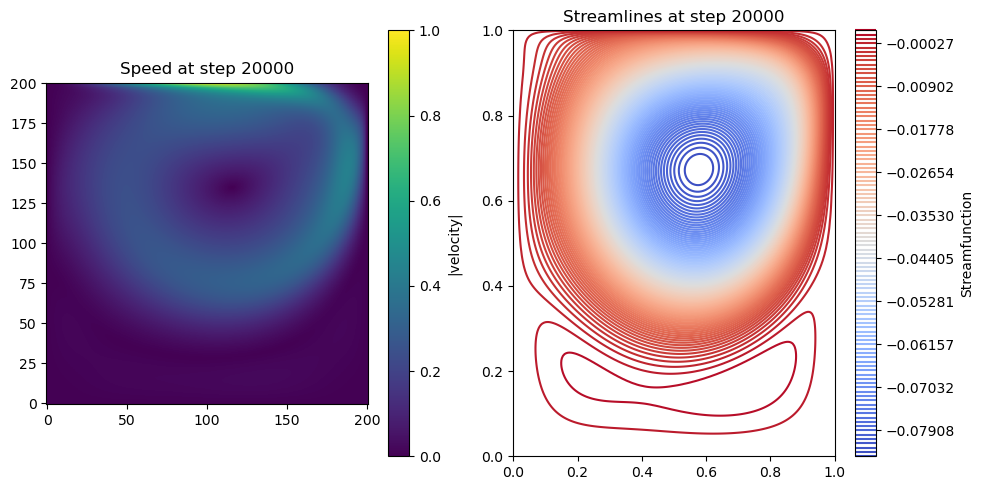

Primary vortex center (y,x): (135, 116),streamfn=-0.0843
Secondary/Tertiary vortex centers: [(2.4444444444444446, 197.38888888888889), (127.54318854886476, 99.6108799887181)]


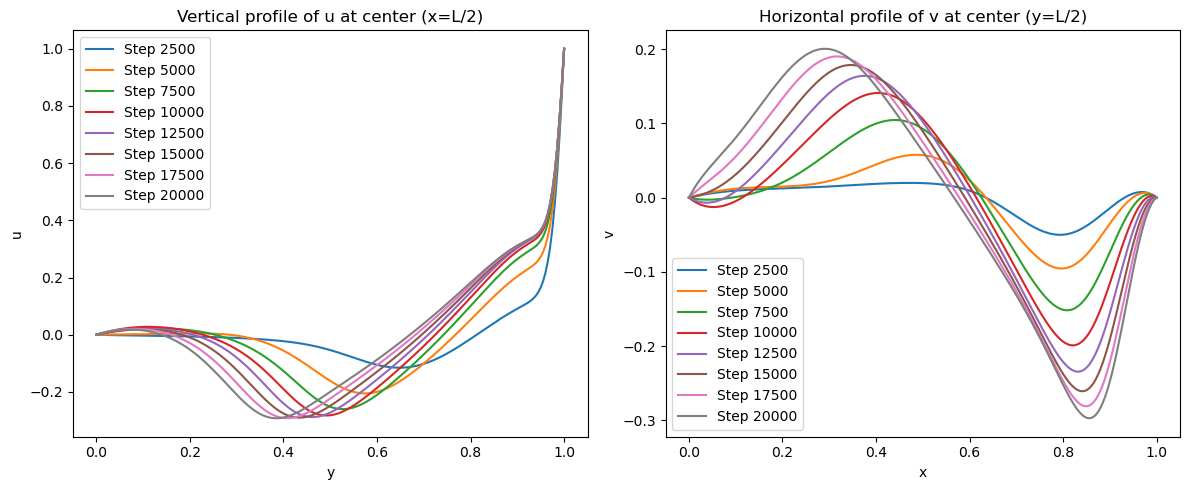

In [35]:
u_profiles = []
v_profiles = []
record_steps = []


vorticity=compute_vorticity(u,v,dx,dy)
stream_fn=solve_streamfn(vorticity,dx,dy)

for step in range(1,num_steps + 1):
    apply_vorticity_bc(stream_fn,u,v,vorticity)
    vorticity=evolve_vorticity(stream_fn,vorticity,dx,dy,dt,visc)
    stream_fn=solve_streamfn(vorticity,dx,dy,psi_guess=stream_fn)
    u,v=streamfn_to_velocity(stream_fn,dx,dy,u,v)

    if step % output_interval == 0:
        print(f"Step: {step}")
        visualize(stream_fn,u,v,step)
        analyze_vortices(stream_fn)

        u_profiles.append(u.copy())
        v_profiles.append(v.copy())
        record_steps.append(step)

visualize_velocity_profiles_over_time(u_profiles, v_profiles, x_vals, y_vals, record_steps)